In [ ]:
from notebooks import *
sg.init(app=None)

INFO     [17:23:21.700] [72535]  52 logging_/init_logging: {logging_yaml: None}

INFO     [17:23:22.015] [72535]  29 api.server_globals/init

INFO     [17:23:22.762] [72535]  31 api.server_globals/init: done

In [ ]:

def opt(*args, **kwargs):
    verbose_keys = ['cache', 'audio']
    verbose(*args, **{k: v for k, v in kwargs.items() if k in verbose_keys})
    par(**{k: v for k, v in kwargs.items() if k not in verbose_keys})

def par(**kwargs):
    """
    Usage:
        par(use=None)                         # No par, no progress bars (easier to see audio read/write and cache hit/miss)
        par(use='sync')                       # No par, cooperative progress bars (no lines printing over each other)
        par(use='dask', scheduler='threads')  # Par, uncooperative progress bars (lines print over each other)
    """
    progress_kwargs(override=kwargs)

def verbose(
    both=None,       # Shorthand, e.g. verbose('warn') = verbose(cache='warn', audio='warn')
    *,
    cache='debug',   # Show cache hit/miss lines # WARNING Frequent hangs during bigger xc_similar_html calls...
    # cache='info',  # Show cache hit/miss chars # WARNING (same)
    # cache='warn',  # Quiet
    audio='debug',   # Show read/write
    # audio='info',  # Show write
    # audio='warn',  # Quiet
):
    if both:
        cache = both
        audio = both
    memory.log.level = cache
    log_levels({'load': audio.upper()})

def n_recs_by_sp_quality(df):
    return (df
        # Count recs by (species, quality)
        .pipe(df_remove_unused_categories)
        .assign(n=1).groupby(['species', 'quality']).n.sum().reset_index()
        # Strip and restore .species cat around .pivot_table to workaround category error when adding .total
        .pipe(df_cat_to_str)
        # Pivot
        .pivot_table(index='species', columns='quality', values='n', fill_value=0, aggfunc='sum',
            margins=True, margins_name='total',  # FIXME 'total' ends up as NaN because we cat .species
        )
        # Restore .species cat
        .reset_index().astype({'species': metadata.species.df.shorthand.dtype}).sort_values('species').set_index('species')
        # Drop columns.name from .pivot_table ('quality')
        .T.pipe(df_set_index_name, None).T
        # Add .total
        # .pipe(df_assign_first, total=lambda df: df.sum(axis=1))
        .pipe(df_reorder_cols, first=['total'])
        # Sort
        .sort_values('total', ascending=False)
    )

to_paths_sliced: [

] |   0% (1) |  0.0s

to_paths_sliced: [

#################################################################################

] | 100% (1) |  0.1s

audio_metadata: [

] |   0% (1) |  0.0s

audio_metadata: [

##################################################################################

] | 100% (1) |  0.1s

feat: [

] |   0% (1) |  0.0s

feat: [

############################################################################################

] | 100% (1) |  0.1s

f_f: [

] |   0% (1) |  0.0s

f_f: [

#############################################################################################

] | 100% (1) |  0.1s

f_p: [

] |   0% (1) |  0.0s

f_p: [

#############################################################################################

] | 100% (1) |  0.1s

to_paths_sliced: [

] |   0% (76) |  0.0s

to_paths_sliced: [

################################################################################

] | 100% (76) |  0.1s

audio_metadata: [

] |   0% (76) |  0.0s

audio_metadata: [

###################################################################              

] |  82% (76) |  0.1s

audio_metadata: [

#################################################################################

] | 100% (76) |  0.2s

feat: [

] |   0% (76) |  0.0s

feat: [

###################################################                                        

] |  56% (76) |  0.1s

feat: [

###########################################################################################

] | 100% (76) |  0.2s

f_f: [

] |   0% (76) |  0.0s

f_f: [

############################################################################################

] | 100% (76) |  0.1s

f_p: [

] |   0% (76) |  0.0s

f_p: [

############################################################################################

] | 100% (76) |  0.1s

d_f2: [

] |   0% (77) |  0.0s

d_f2: [

###########################################################################################

] | 100% (77) |  0.1s

d_fc: [

] |   0% (77) |  0.0s

d_fc: [

###########################################################################################

] | 100% (77) |  0.1s

d_p2: [

] |   0% (77) |  0.0s

d_p2: [

###########################################################################################

] | 100% (77) |  0.1s

d_pc: [

] |   0% (77) |  0.0s

d_pc: [

###########################################################################################

] | 100% (77) |  0.1s

audio: [

] |   0% (10) |  0.0s

audio: [

####################################                                                      

] |  40% (10) |  0.1s

audio: [

##########################################################################################

] | 100% (10) |  0.2s

spectro: [

] |   0% (10) |  0.0s

spectro: [

########################################################################################

] | 100% (10) |  0.1s

plot_slice: [

] |   0% (10) |  0.0s

plot_slice: [

] |   0% (10) |  0.1s

plot_slice: [

#################                                                                    

] |  20% (10) |  0.3s

plot_slice: [

####################################################################                 

] |  80% (10) |  0.4s

plot_slice: [

#####################################################################################

] | 100% (10) |  0.5s

,xc_id,d_slp,d_f2,d_p2,d_fc,d_pc,species,slice,quality,type,subspecies,background_species,recordist,elevation,place,remarks,bird_seen,playback_used,recs_for_sp
0,381417,0.0,0.0,0.0,0.0,0.0,YHBL,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",A,song,,[],Sue Riffe,2000 m,"Carpenter Ranch, Routt County, Colorado, United States",Natural vocalization from cattails around a small pond.,yes,no,81
1,351645,3.54,31.1,0.0878,0.12,0.341,GWTE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",B,call,,[],Janine McCabe,750 m,"Tucson, Pima County, Arizona, United States",Green-winged Teal male were displaying for females on a pond at about 20 meters distance away. This is a park setting in Tucson with large mesquite trees surrounding the pond. The recording was n...,None,None,45
2,72510,3.54,24.9,0.0869,0.0895,0.351,GWTE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",B,call,,[],Paul Driver,5 m,"Taylor's Refuge, Cinnaminson, NJ, United States","birds not seen, male burps and female chattering",None,None,45
3,265347,3.54,31.8,0.0831,0.156,0.351,GWTE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",B,call,,['AMCR'],Eric Hough,2500 m,"River Reservoir, Apache-Sitgreaves National Forest, Greer, Apache County, Arizona, United States",Large flock calling. Amplification and high pass filter used.,yes,no,45
4,143632,3.54,39.2,0.118,0.0886,0.39,GWTE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",A,"call, female, male",,[],Paul Marvin,0 m,"Tijuana Slough NWR, Imperial Beach, San Diego County, California, United States",Male whistle calls and female calls,yes,no,45
5,365404,3.57,32.0,0.0924,0.147,0.425,GRHE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",B,alarm call,virescens,[],Juan Carlos Pérez M.,1400 m,"Santuario Bosque de Niebla, Mexico","Cuerpo de agua dentro del bosque de niebla, audio amplificado 20dB y filtrado High pass.",yes,no,51
6,293877,3.54,38.4,0.109,0.0827,0.43,GWTE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",A,call,,"['NOPI', 'MALL']",Bruce Lagerquist,0 m,"Blaine, Whatcom County, Washington, United States",Teals were in a mixed flock of including Northern Pintails and Mallards. Recording starts with Green-Winged Teal at 0:11 Northern Pintails are the dominant calls heard. The background noise is made...,yes,no,45
7,218542,3.54,31.1,0.0975,0.116,0.434,GWTE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",B,call,,[],Peter Boesman,? m,"Sequoyah NWR, OK, United States",ID certainty 100%. (Archiv. tape 75 side A track 19 seq. A),None,None,45
8,218543,3.54,26.4,0.0965,0.0984,0.447,GWTE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",B,call,,[],Peter Boesman,? m,"Sequoyah NWR, OK, United States",ID certainty 100%. (Archiv. tape 75 side A track 32 seq. B),None,None,45
9,354707,3.54,32.3,0.105,0.11,0.46,GWTE,"<!-- Wrap in case x contains an audio elem, which would fool our selector below -->",A,call,,[],Frank Lambert,0 m,"Safety Sound, Nome Census Area, Alaska, United States",,yes,no,45

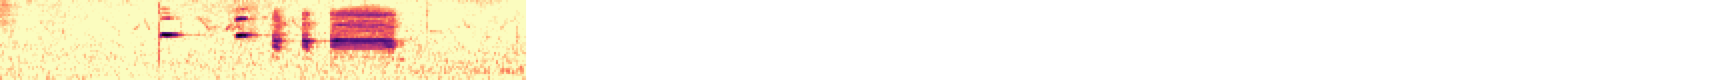
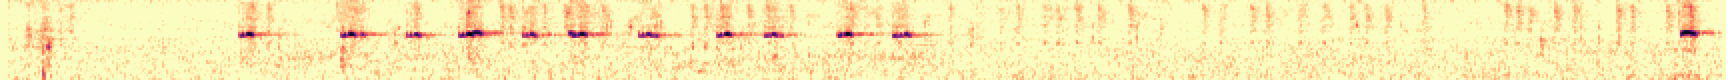
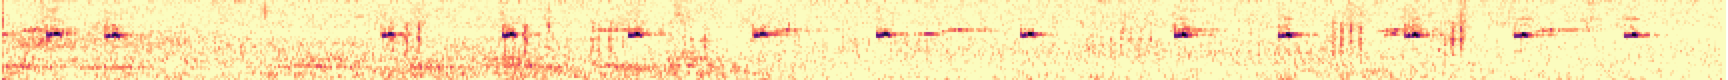
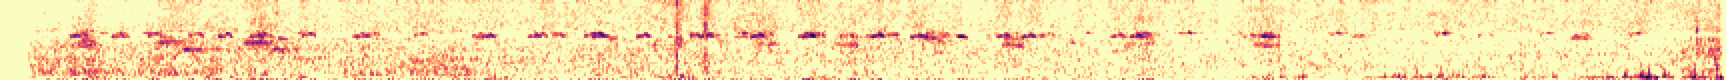
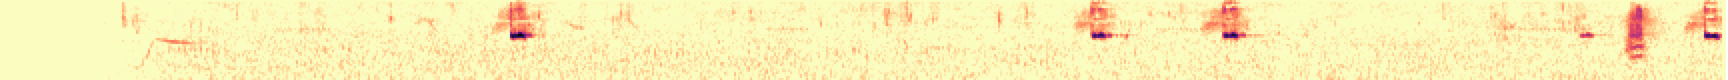
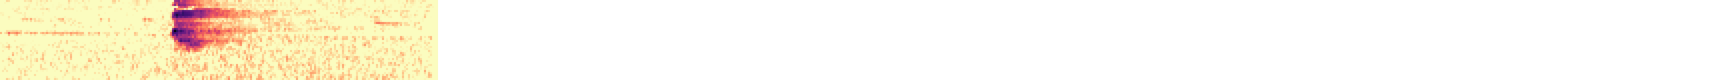
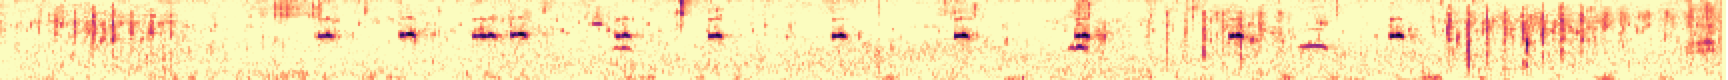
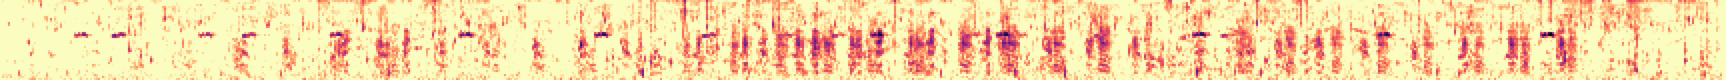
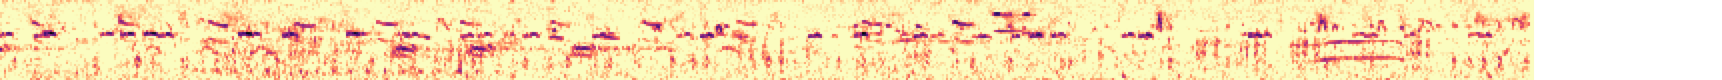
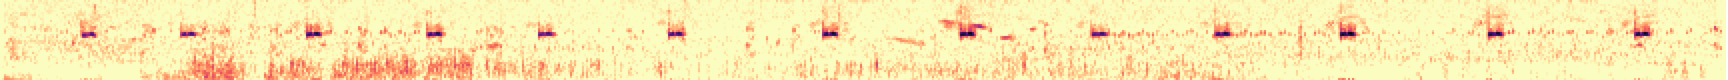

peak memory: 861.92 MiB, increment: 113.49 MiB

In [ ]:
%%memit -c
# Optimize perf
#   - NOTE n_sp=None -> 27035/35233 recs because quality='ab'
opt('warn', use='dask', scheduler='threads')  # Quiet + par + progress bars
# opt('warn', use='sync')
# opt('debug', use='sync')  # Verbose + sync + no progress bars
with ExitStack() as stack:
    stack.enter_context(cache_control(
        tags_fail_on_miss=['rec'],  # Require warmed cache for 'rec' funcs
        tags_refresh=['recs'],  # Measure un-warmed cache for 'recs' funcs
    ))
    display(
        xc_similar_html(
            sp_cols='species',

            # Perf bottlenecks
            #   - meta: O(n) cache hits
            #   - feat: O(n) cache hits
            #   - p:    O(n) sg.search.predict_proba [@cache would achieve perf ~between meta and feat, which is only ~2x speedup]
            # xc_id=381417, n_total=10,   n_sp=1,     # t[4.0s] n_recs[   32,0]
            xc_id=381417, n_total=10,   n_sp=2,     # t[    ] n_recs[       ]
            # xc_id=381417, n_total=10,   n_sp=10,    # t[7.1s] n_recs[  717,0]
            # xc_id=381417, n_total=10,   n_sp=40,    # t[ 25s] n_recs[ 3879,1]
            # xc_id=381417, n_total=10,   n_sp=80,    # t[ 51s] n_recs[ 8203,1]
            # xc_id=381417, n_total=10,   n_sp=160,   # t[111s] n_recs[15284,1]
            # xc_id=381417, n_total=10,   n_sp=None,  # t[192s] n_recs[27033,2]

            view=False,  # For .pipe(n_recs_by_sp_quality): disable html view else junk .species values
        )
        # .pipe(n_recs_by_sp_quality)
    )

In [ ]:
# Use /species
xc_species_html(species='WTSP', n_recs=3)

In [ ]:
# Use /similar
opt('warn', use='dask', scheduler='threads')  # Quiet + par + progress bars
xc_similar_html(
    # view=False,
    # n_total=20,
    # n_sp_recs=1,

    # Examples (bad/good)
    # xc_id=381417,  # YHBL (bad)
    xc_id=173272,  # LOSH (bad)
    # xc_id=15222,   # JUTI (bad)
    # xc_id=408021,  # WREN (good)
    # xc_id=348142,  # PSFL (good)
    # xc_id=378376,  # WCSP (good)
    # xc_id=381582,  # COYE (good)
    # xc_id=416558,  # COYE (good)
    # xc_id=329879,  # WTSP (good)

    n_sp=3,
    # n_sp=10,
    # n_sp=20,
    # n_sp=40,
    # n_sp=80,
    # n_sp=160,
    # n_sp=None,

)